# **<span>PARTIE 2 : PHASE DE PREPARATION DES DONNEES </span>**

Import des Bibliothèques 

In [1]:
import pandas as pd
import numpy as np
import os
import re

# DIAGNOSTIC ET NETTOYAGE DES TABLES

* Chargement des données brutes 

In [12]:
caract_2023 = pd.read_csv("caract-2023.csv", sep=";")
lieux_2023 = pd.read_csv("lieux-2023.csv", sep=";")
usagers_2023 = pd.read_csv("usagers-2023.csv", sep=";")
vehicules_2023 = pd.read_csv("vehicules-2023.csv", sep=";")


/var/folders/ft/zmn0khps76jgx6fn9ncy5gw40000gn/T/ipykernel_23786/361049351.py:2: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  lieux_2023 = pd.read_csv("lieux-2023.csv", sep=";")


* DIAGNOSTIC CARACTÉRISTIQUES 2023

In [13]:
def diagnostic(df, year):
    print(f"\n=== DIAGNOSTIC CARACT {year} ===")
    print(f"Nombre de lignes : {df.shape[0]}")
    print(f"Nombre de colonnes : {df.shape[1]}\n")
    print("Types des colonnes :")
    print(df.dtypes, "\n")
    print("Valeurs manquantes :")
    print(df.isna().sum(), "\n")

    print("Vérification jour/mois/an :")
    print("Jour hors plage :", df[(df['jour'] < 1) | (df['jour'] > 31)].shape[0])
    print("Mois hors plage :", df[(df['mois'] < 1) | (df['mois'] > 12)].shape[0])
    print("Année incohérente :", df[df['an'] != int(year)].shape[0], "\n")

    bad_hrmn = df[~df['hrmn'].astype(str).str.match(r'^\d{1,2}:\d{2}$', na=False)]
    print("Heures/minutes incorrectes :", len(bad_hrmn))

    print("lat avec virgule :", df['lat'].astype(str).str.contains(",").sum())
    print("long avec virgule :", df['long'].astype(str).str.contains(",").sum(), "\n")

diagnostic(caract_2023, "2023")



=== DIAGNOSTIC CARACT 2023 ===
Nombre de lignes : 54822
Nombre de colonnes : 15

Types des colonnes :
Num_Acc     int64
jour        int64
mois        int64
an          int64
hrmn       object
lum         int64
dep        object
com        object
agg         int64
int         int64
atm         int64
col         int64
adr        object
lat        object
long       object
dtype: object 

Valeurs manquantes :
Num_Acc       0
jour          0
mois          0
an            0
hrmn          0
lum           0
dep           0
com           0
agg           0
int           0
atm           0
col           0
adr        1389
lat           0
long          0
dtype: int64 

Vérification jour/mois/an :
Jour hors plage : 0
Mois hors plage : 0
Année incohérente : 0 

Heures/minutes incorrectes : 0
lat avec virgule : 54822
long avec virgule : 54822 



* NETTOYAGE CARACTÉRISTIQUES 2023

In [14]:
caract_2023 = caract_2023.rename(columns={"Accident_Id": "Num_Acc"})

# Corriger lat/long
caract_2023["lat"] = caract_2023["lat"].astype(str).str.replace(",", ".", regex=False).astype(float)
caract_2023["long"] = caract_2023["long"].astype(str).str.replace(",", ".", regex=False).astype(float)

# Nettoyage adr
caract_2023["adr"] = caract_2023["adr"].replace({"": np.nan, " ": np.nan})

# Découper hrmn
def split_hrmn(df):
    df["heure"] = df["hrmn"].str.split(":").str[0].astype(int)
    df["minute"] = df["hrmn"].str.split(":").str[1].astype(int)
    return df

caract_2023 = split_hrmn(caract_2023)

* DIAGNOSTIC LIEUX 2023

In [15]:
def diagnostic_lieux(df, year):
    print(f"\n=== DIAGNOSTIC LIEUX {year} ===")
    print(df.info())
    print("Valeurs manquantes :")
    print(df.isna().sum())
    print("Doublons Num_Acc :", df["Num_Acc"].duplicated().sum())

diagnostic_lieux(lieux_2023, "2023")


=== DIAGNOSTIC LIEUX 2023 ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70860 entries, 0 to 70859
Data columns (total 18 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Num_Acc  70860 non-null  int64 
 1   catr     70860 non-null  int64 
 2   voie     58113 non-null  object
 3   v1       70860 non-null  int64 
 4   v2       5884 non-null   object
 5   circ     70860 non-null  int64 
 6   nbv      70860 non-null  object
 7   vosp     70860 non-null  int64 
 8   prof     70860 non-null  int64 
 9   pr       70860 non-null  object
 10  pr1      70860 non-null  object
 11  plan     70860 non-null  int64 
 12  lartpc   31 non-null     object
 13  larrout  70860 non-null  object
 14  surf     70860 non-null  int64 
 15  infra    70860 non-null  int64 
 16  situ     70860 non-null  int64 
 17  vma      70860 non-null  int64 
dtypes: int64(11), object(7)
memory usage: 9.7+ MB
None
Valeurs manquantes :
Num_Acc        0
catr           0
voie     

 * NETTOYAGE LIEUX 2023

In [16]:
def nettoyer_lieux(df):
    df = df.copy()
    cols = ["voie", "v2", "nbv", "pr", "pr1", "lartpc", "larrout"]
    for col in cols:
        df[col] = df[col].replace({"": np.nan, " ": np.nan})

    for col in ["voie", "v2", "nbv", "pr", "pr1", "larrout"]:
        df[col] = pd.to_numeric(df[col], errors="coerce")

    if "lartpc" in df.columns:
        df = df.drop(columns=["lartpc"])

    plage = {
        "catr": (1, 9),
        "circ": (1, 9),
        "prof": (0, 9),
        "plan": (1, 9),
        "surf": (1, 7),
        "infra": (0, 9),
        "situ": (0, 9),
        "vma": (0, 130)
    }

    for col, (minv, maxv) in plage.items():
        df.loc[(df[col] < minv) | (df[col] > maxv), col] = np.nan

    return df

lieux_2023_clean = nettoyer_lieux(lieux_2023)

* DIAGNOSTIC USAGERS 2023

In [17]:
def diagnostic_usagers(df, year):
    print(f"\n=== DIAGNOSTIC USAGERS {year} ===\n")
    print(df.info())
    print("\nValeurs manquantes :\n", df.isna().sum())
    print("Doublons Num_Acc + id_usager :", df.duplicated(subset=["Num_Acc", "id_usager"]).sum(), "\n")

diagnostic_usagers(usagers_2023, "2023")


=== DIAGNOSTIC USAGERS 2023 ===

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125789 entries, 0 to 125788
Data columns (total 16 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Num_Acc      125789 non-null  int64  
 1   id_usager    125789 non-null  object 
 2   id_vehicule  125789 non-null  object 
 3   num_veh      125789 non-null  object 
 4   place        125789 non-null  int64  
 5   catu         125789 non-null  int64  
 6   grav         125789 non-null  int64  
 7   sexe         125789 non-null  int64  
 8   an_nais      123191 non-null  float64
 9   trajet       125789 non-null  int64  
 10  secu1        125789 non-null  int64  
 11  secu2        125789 non-null  int64  
 12  secu3        125789 non-null  int64  
 13  locp         125789 non-null  int64  
 14  actp         125789 non-null  object 
 15  etatp        125789 non-null  int64  
dtypes: float64(1), int64(11), object(4)
memory usage: 15.4+ MB
None

Valeurs man

* NETTOYAGE USAGERS 2023

In [18]:
def nettoyer_usagers(df):
    df = df.copy()
    df["id_vehicule"] = df["id_vehicule"].astype(str).str.replace(" ", "").str.replace("\xa0", "")
    df["num_veh"] = df["num_veh"].astype(str).str.replace(" ", "").str.replace("\xa0", "")

    aberrants = [-1, 0, 99, 999, "99", "0"]

    for col in df.columns:
        df[col] = df[col].replace(aberrants, np.nan)

    plages = {
        "sexe": (1, 2),
        "grav": (1, 4),
        "trajet": (1, 9),
        "locp": (1, 9),
        "actp": (1, 13),
        "place": (1, 9)
    }

    for col, (minv, maxv) in plages.items():
        df[col] = pd.to_numeric(df[col], errors="coerce")
        df.loc[(df[col] < minv) | (df[col] > maxv), col] = np.nan

    return df

usagers_2023_clean = nettoyer_usagers(usagers_2023)

* DIAGNOSTIC VEHICULES 2023

In [19]:
def diagnostic_vehicules(df, year):
    print(f"\n=== DIAGNOSTIC VEHICULES {year} ===\n")
    print(df.info())
    print("Doublons Num_Acc + id_vehicule :", df.duplicated(subset=["Num_Acc", "id_vehicule"]).sum())

diagnostic_vehicules(vehicules_2023, "2023")


=== DIAGNOSTIC VEHICULES 2023 ===

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93585 entries, 0 to 93584
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Num_Acc      93585 non-null  int64  
 1   id_vehicule  93585 non-null  object 
 2   num_veh      93585 non-null  object 
 3   senc         93585 non-null  int64  
 4   catv         93585 non-null  int64  
 5   obs          93585 non-null  int64  
 6   obsm         93585 non-null  int64  
 7   choc         93585 non-null  int64  
 8   manv         93585 non-null  int64  
 9   motor        93585 non-null  int64  
 10  occutc       838 non-null    float64
dtypes: float64(1), int64(8), object(2)
memory usage: 7.9+ MB
None
Doublons Num_Acc + id_vehicule : 0


Import des librairies utiles au module 

* NETTOYAGE VÉHICULES 2023

In [20]:
def nettoyer_vehicules(df):
    df = df.copy()
    df["id_vehicule"] = df["id_vehicule"].astype(str).str.replace(" ", "").str.replace("\xa0", "")
    df["num_veh"] = df["num_veh"].astype(str).str.replace(" ", "").str.replace("\xa0", "")

    aberrants = [-1, 0, 99, 999, "99", "999", "0"]

    for col in df.columns:
        df[col] = df[col].replace(aberrants, np.nan)

    plages = {
        "senc": (1, 3),
        "catv": (1, 39),
        "obs": (0, 9),
        "obsm": (0, 9),
        "choc": (1, 9),
        "manv": (1, 18),
        "motor": (1, 9)
    }

    for col, (minv, maxv) in plages.items():
        df[col] = pd.to_numeric(df[col], errors="coerce")
        df.loc[(df[col] < minv) | (df[col] > maxv), col] = np.nan

    return df

vehicules_2023_clean = nettoyer_vehicules(vehicules_2023)

# SUPPRESSION COLONNES INUTILES

* TABLE CARACT

In [22]:
cols_drop_caract = [
    "dep", "com", "hrmn", "int",   # inutiles
    "adr"                           # déjà supprimé mais au cas où
]
caract_2023.drop(columns=cols_drop_caract, inplace=True, errors="ignore")

* TABLE LIEUX 

In [23]:
cols_drop_lieux = [
    "voie",      # trop vide
    "v1",        # identifiant inutile
    "larrout",   # trop vide
    "v2", "pr1"  # déjà supprimés mais on sécurise
]
lieux_2023_clean.drop(columns=cols_drop_lieux, inplace=True, errors="ignore")

* TABLE USAGERS

In [34]:
cols_drop_usagers = [
    "id_usager",
    "num_veh",
    "trajet",
    "locp",
    "actp",
    "etatp",
    "secu1", "secu2", "secu3"  # déjà présents mais on sécurise
]
usagers_2023_clean.drop(columns=cols_drop_usagers, inplace=True, errors="ignore")


* TABLE VEHICULES

In [31]:
cols_drop_veh = [
    "num_veh",   # doublon
    "obs",
    "obsm",
    "occutc"     # déjà supprimé mais on sécurise
]
vehicules_2023_clean.drop(columns=cols_drop_veh, inplace=True, errors="ignore")


# CREATION DE VARIABLES 

* Première variable 

In [35]:
def periode_journee(h):
    if 0 <= h < 6:
        return "Nuit"
    elif 6 <= h < 12:
        return "Matin"
    elif 12 <= h < 18:
        return "Après-midi"
    else:
        return "Soir"

caract_2023["periode"] = caract_2023["heure"].apply(periode_journee)

* Deuxième variable

In [37]:
def simplifier_grav(x):
    return 1 if x in [3, 4] else 0

usagers_2023_clean["grav_simpl"] = usagers_2023_clean["grav"].apply(simplifier_grav)
usagers_2023_clean["age"] = 2023 - usagers_2023_clean["an_nais"]

KeyError: 'an_nais'

* Troisième variable 

In [28]:
def tranche_age(a):
    if pd.isna(a): 
        return None
    elif a < 18:
        return "Mineur"
    elif a < 25:
        return "18–24"
    elif a < 40:
        return "25–39"
    elif a < 60:
        return "40–59"
    else:
        return "60+"

usagers_2023_clean["tranche_age"] = usagers_2023_clean["age"].apply(tranche_age)

KeyError: 'age'

In [21]:
from unidecode import unidecode 
import re
from nltk.stem import SnowballStemmer
import nltk
from nltk.corpus import stopwords

1. **Collecte des données**  
Récupération des textes à analyser (web scraping, bases de données, API, fichiers).
Exemples : documents, tweets, articles, etc.

In [180]:
with open("article.txt", "r", encoding="utf-8") as f: 
    texte = f.read() 
print("Aperçu du texte :") 
print(texte[:500]) # pour vérifier que le texte se charge bien

Aperçu du texte :

Sécurité routière : en 2023, le nombre de morts sur les routes de France en baisse par rapport à 2022
Malgré la diminution du nombre de morts sur les autoroutes, ce chiffre est en hausse de 4 % par rapport à 2019, année de référence pour la Sécurité routière.
Le Monde avec AFP
Publié le 01 février 2024 à 12h22 
Temps de Lecture 1 min.

Un total de 3 170 personnes sont mortes sur les routes de France métropolitaine en 2023, soit 3 % de moins qu’en 2022, a annoncé, jeudi 1er février, la Sécurité 


In [181]:
print(f"Le document contient {len(texte)} caractères.\n")
liste_mots = texte.split()   # Sépare les mots en fonction de l’espace
print(f"Le document contient {len(liste_mots)} mots.")




Le document contient 2410 caractères.

Le document contient 421 mots.


2. **Prétraitement du texte**  
On commence par le Nettoyage avec : 
- La Mise en minuscules (pour uniformiser). 
- La suppression des caractères spéciaux (ponctuation, chiffres inutiles).   
- La Suppression des espaces superflus.  
- La Correction orthographique.   
- La Suppression des stop words 


In [182]:
texte_min = texte.lower()
print(texte_min)


sécurité routière : en 2023, le nombre de morts sur les routes de france en baisse par rapport à 2022
malgré la diminution du nombre de morts sur les autoroutes, ce chiffre est en hausse de 4 % par rapport à 2019, année de référence pour la sécurité routière.
le monde avec afp
publié le 01 février 2024 à 12h22 
temps de lecture 1 min.

un total de 3 170 personnes sont mortes sur les routes de france métropolitaine en 2023, soit 3 % de moins qu’en 2022, a annoncé, jeudi 1er février, la sécurité routière.
l’année écoulée a été marquée par la baisse du nombre de morts dans toutes les catégories d’usagers de la route, à l’exception des utilisateurs d’engins de déplacements personnels motorisés (edpm) comme les trottinettes, avec 42 tués, en hausse de 7 % par rapport à 2022.

la déléguée interministérielle à la sécurité routière, florence guillaume, a insisté sur les « chiffres encourageants » de l’observatoire national interministériel de la sécurité routière (onisr), présentées à la pres

In [183]:
texte_sans_accents = unidecode(texte_min)
print(texte_sans_accents[:300])



securite routiere : en 2023, le nombre de morts sur les routes de france en baisse par rapport a 2022
malgre la diminution du nombre de morts sur les autoroutes, ce chiffre est en hausse de 4 % par rapport a 2019, annee de reference pour la securite routiere.
le monde avec afp
publie le 01 fevrier 


In [184]:

texte_nettoye = re.sub(r'[0-9]{4}', 'annee', texte_sans_accents) 
print(texte_nettoye)



securite routiere : en annee, le nombre de morts sur les routes de france en baisse par rapport a annee
malgre la diminution du nombre de morts sur les autoroutes, ce chiffre est en hausse de 4 % par rapport a annee, annee de reference pour la securite routiere.
le monde avec afp
publie le 01 fevrier annee a 12h22 
temps de lecture 1 min.

un total de 3 170 personnes sont mortes sur les routes de france metropolitaine en annee, soit 3 % de moins qu'en annee, a annonce, jeudi 1er fevrier, la securite routiere.
l'annee ecoulee a ete marquee par la baisse du nombre de morts dans toutes les categories d'usagers de la route, a l'exception des utilisateurs d'engins de deplacements personnels motorises (edpm) comme les trottinettes, avec 42 tues, en hausse de 7 % par rapport a annee.

la deleguee interministerielle a la securite routiere, florence guillaume, a insiste sur les << chiffres encourageants >> de l'observatoire national interministeriel de la securite routiere (onisr), presentees 

In [185]:
texte_nettoye_2 = re.sub(r"[^a-z]+", ' ', texte_nettoye) 
print(texte_nettoye_2)

 securite routiere en annee le nombre de morts sur les routes de france en baisse par rapport a annee malgre la diminution du nombre de morts sur les autoroutes ce chiffre est en hausse de par rapport a annee annee de reference pour la securite routiere le monde avec afp publie le fevrier annee a h temps de lecture min un total de personnes sont mortes sur les routes de france metropolitaine en annee soit de moins qu en annee a annonce jeudi er fevrier la securite routiere l annee ecoulee a ete marquee par la baisse du nombre de morts dans toutes les categories d usagers de la route a l exception des utilisateurs d engins de deplacements personnels motorises edpm comme les trottinettes avec tues en hausse de par rapport a annee la deleguee interministerielle a la securite routiere florence guillaume a insiste sur les chiffres encourageants de l observatoire national interministeriel de la securite routiere onisr presentees a la presse au centre de medecine physique et de readaptation d

In [186]:
# Télécharger la liste des stopwords (une seule fois)
nltk.download('stopwords')

# Récupérer la liste française
stopWords = stopwords.words('french')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ibouchichenelina/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [187]:
liste_mots = texte_nettoye.split()
liste_mots = [word for word in liste_mots if word not in stopWords]

print(liste_mots)

['securite', 'routiere', ':', 'annee,', 'nombre', 'morts', 'routes', 'france', 'baisse', 'rapport', 'a', 'annee', 'malgre', 'diminution', 'nombre', 'morts', 'autoroutes,', 'chiffre', 'hausse', '4', '%', 'rapport', 'a', 'annee,', 'annee', 'reference', 'securite', 'routiere.', 'monde', 'afp', 'publie', '01', 'fevrier', 'annee', 'a', '12h22', 'temps', 'lecture', '1', 'min.', 'total', '3', '170', 'personnes', 'mortes', 'routes', 'france', 'metropolitaine', 'annee,', '3', '%', 'moins', "qu'en", 'annee,', 'a', 'annonce,', 'jeudi', '1er', 'fevrier,', 'securite', 'routiere.', "l'annee", 'ecoulee', 'a', 'ete', 'marquee', 'baisse', 'nombre', 'morts', 'toutes', 'categories', "d'usagers", 'route,', 'a', "l'exception", 'utilisateurs', "d'engins", 'deplacements', 'personnels', 'motorises', '(edpm)', 'comme', 'trottinettes,', '42', 'tues,', 'hausse', '7', '%', 'rapport', 'a', 'annee.', 'deleguee', 'interministerielle', 'a', 'securite', 'routiere,', 'florence', 'guillaume,', 'a', 'insiste', '<<', 'chi

* Ensuite la Tokenisation :   
Découper le texte en unités de base : mots, n-grammes, ou phrases.
Exemple : "Je mange une pomme." → ["Je", "mange", "une", "pomme"]  

In [188]:
liste_mots = texte.split()

print(f"L'article contient {len(liste_mots)} mots.")
print(f"Les 20 premiers mots : {liste_mots[:20]} \n")



L'article contient 421 mots.
Les 20 premiers mots : ['Sécurité', 'routière', ':', 'en', '2023,', 'le', 'nombre', 'de', 'morts', 'sur', 'les', 'routes', 'de', 'France', 'en', 'baisse', 'par', 'rapport', 'à', '2022'] 



* Puis la Normalisation :   
Lemmatisation : ramener un mot à sa forme de base (ex : "mangé" → "manger").  
Stemming : réduire un mot à sa racine (ex : "mangé" → "mang").  
Ces deux étapes permettent de regrouper différentes formes d’un mot.

In [189]:
# Télécharger la liste des stopwords (une seule fois)
nltk.download('stopwords')

# Récupérer la liste française
stopWords = stopwords.words('french')

print(len(stopWords))
print(stopWords[:20])  # pour voir un aperçu

157
['au', 'aux', 'avec', 'ce', 'ces', 'dans', 'de', 'des', 'du', 'elle', 'en', 'et', 'eux', 'il', 'ils', 'je', 'la', 'le', 'les', 'leur']


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ibouchichenelina/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [190]:
# Télécharger la liste des stopwords (une seule fois)
nltk.download('stopwords')

# Récupérer la liste française
stopWords = stopwords.words('french')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ibouchichenelina/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [191]:
# creation du stemmer
stemmer = SnowballStemmer("french")

In [192]:
# Création d'une fonction pour supprimer les sw
def no_stop_word(string, stopWords):

    """
    Supprime les stop words d'un texte.

    Paramètres
    ----------

    string : chaine de caractère.

    stopWords : liste de mots à exclure. 
    
    ----------
    Sortie : string sans stopWords
    """
    string = ' '.join([word for word in string.split() if word not in stopWords])
    return string
    
    

# Création d'une fonction pour stemmatiser chaque mot d'un text 
def stemmatise_text(text, stemmer):

    """
    Stemmatise un texte : Ramène les mots d'un texte à leur racine (peut créer des mots qui n'existe pas).

    Paramètres
    ----------

    text : Chaine de caractères.

    stemmer : Stemmer de NLTK.
    
    ----------
    Sortie : string qui contient la forme stemmatisée des mots
    """
    string = ' '.join([stemmer.stem(word) for word in text.split()])
    return string
    


In [193]:
texte_stemmatise = stemmatise_text(texte, stemmer)

print("Aperçu du texte stemmatisé :")
print(texte_stemmatise[:500])


Aperçu du texte stemmatisé :
sécur routi : en 2023, le nombr de mort sur le rout de franc en baiss par rapport à 2022 malgr la diminu du nombr de mort sur le autoroutes, ce chiffr est en hauss de 4 % par rapport à 2019, anné de référent pour la sécur routière. le mond avec afp publi le 01 févri 2024 à 12h22 temp de lectur 1 min. un total de 3 170 person sont mort sur le rout de franc métropolitain en 2023, soit 3 % de moin qu’en 2022, a annonce, jeud 1er février, la sécur routière. l’ann écoul a été marqu par la baiss du no


3. **Vectorisation**    
Transformation du texte en vecteurs numériques (Bag of Words, TF-IDF, embeddings).

In [194]:
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from collections import defaultdict

BAG OF WORD

In [195]:
texte_final = texte_stemmatise
corpus = [texte_final]

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus)

print(X.toarray())
print(vectorizer.get_feature_names_out())

[[ 1  1  1  1  1  1  1  1  1  1  1  2  1  1  4  7  1  2  1  1  1  1  1  1
   1  1  1  1  1  2  3  1  3  1  1  1  1  1  1  2  4  7  1  1  1  2  1  1
   4  1  1  1  1  1  2  2 35  1  1  2  1  3  2  1  2  1  1 17  1  1  2  1
   3  3  1  1  2  1  1  1  3  1  1  1  2  1 16 19  1  1  1  2  1  1  1  1
   7  2  1  2  1  1  2  2  4  1  1  1  1  2  1  8  1  1  2  1  1  1  1  1
   5  1  2  1  1  1  2  1  7  1  1  1  5  1  7  3  1  2  1  1  1  2  2  1
   8  1  7  1  1  1  1  1  1  3  1  1  2  4  1  2  1  1  2  1  3]]
['000' '01' '016' '10' '11' '12h22' '170' '18' '19' '1er' '200' '2019'
 '2020' '2021' '2022' '2023' '2024' '226' '232' '273' '40' '42' '440'
 '525' '707' '881' 'abon' 'affilée' 'afp' 'agglomer' 'ann' 'annonce'
 'anné' 'articl' 'assembl' 'au' 'auss' 'automob' 'autorout' 'autoroutes'
 'avec' 'baiss' 'barr' 'bobigny' 'catégor' 'ce' 'centr' 'chez' 'chiffr'
 'cmpr' 'comm' 'constat' 'covid' 'création' 'cyclist' 'dan' 'de' 'del'
 'deux' 'diminu' 'discut' 'du' 'déces' 'délégu' 'déplac' 'détai

Les N-grammes 

In [196]:

# 1er document du corpus
print(f"Notre 1er document : {corpus[0]} \n")

# Liste des bigrammes
print(f"La liste des bigrammes présents dans le 1er document : {list(nltk.bigrams(corpus[0].split()))}")


Notre 1er document : sécur routi : en 2023, le nombr de mort sur le rout de franc en baiss par rapport à 2022 malgr la diminu du nombr de mort sur le autoroutes, ce chiffr est en hauss de 4 % par rapport à 2019, anné de référent pour la sécur routière. le mond avec afp publi le 01 févri 2024 à 12h22 temp de lectur 1 min. un total de 3 170 person sont mort sur le rout de franc métropolitain en 2023, soit 3 % de moin qu’en 2022, a annonce, jeud 1er février, la sécur routière. l’ann écoul a été marqu par la baiss du nombr de mort dan tout le catégor d’usager de la route, à l’except de utilis d’engin de déplac personnel motoris (edpm) comm le trottinettes, avec 42 tues, en hauss de 7 % par rapport à 2022. la délégu interministériel à la sécur routière, florenc guillaume, a insist sur le « chiffr encourag » de l’observatoir national interministériel de la sécur routi (onisr), présent à la press au centr de médecin physiqu et de réadapt de bobigny (cmpr). lir auss | articl réserv à nos abon 

La représentation tf-idf

In [197]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)

print(X.toarray())


[[0.01830323 0.01830323 0.01830323 0.01830323 0.01830323 0.01830323
  0.01830323 0.01830323 0.01830323 0.01830323 0.01830323 0.03660647
  0.01830323 0.01830323 0.07321294 0.12812264 0.01830323 0.03660647
  0.01830323 0.01830323 0.01830323 0.01830323 0.01830323 0.01830323
  0.01830323 0.01830323 0.01830323 0.01830323 0.01830323 0.03660647
  0.0549097  0.01830323 0.0549097  0.01830323 0.01830323 0.01830323
  0.01830323 0.01830323 0.01830323 0.03660647 0.07321294 0.12812264
  0.01830323 0.01830323 0.01830323 0.03660647 0.01830323 0.01830323
  0.07321294 0.01830323 0.01830323 0.01830323 0.01830323 0.01830323
  0.03660647 0.03660647 0.64061319 0.01830323 0.01830323 0.03660647
  0.01830323 0.0549097  0.03660647 0.01830323 0.03660647 0.01830323
  0.01830323 0.31115498 0.01830323 0.01830323 0.03660647 0.01830323
  0.0549097  0.0549097  0.01830323 0.01830323 0.03660647 0.01830323
  0.01830323 0.01830323 0.0549097  0.01830323 0.01830323 0.01830323
  0.03660647 0.01830323 0.29285174 0.34776145 0.

In [198]:
print(vectorizer.get_feature_names_out())

['000' '01' '016' '10' '11' '12h22' '170' '18' '19' '1er' '200' '2019'
 '2020' '2021' '2022' '2023' '2024' '226' '232' '273' '40' '42' '440'
 '525' '707' '881' 'abon' 'affilée' 'afp' 'agglomer' 'ann' 'annonce'
 'anné' 'articl' 'assembl' 'au' 'auss' 'automob' 'autorout' 'autoroutes'
 'avec' 'baiss' 'barr' 'bobigny' 'catégor' 'ce' 'centr' 'chez' 'chiffr'
 'cmpr' 'comm' 'constat' 'covid' 'création' 'cyclist' 'dan' 'de' 'del'
 'deux' 'diminu' 'discut' 'du' 'déces' 'délégu' 'déplac' 'détail' 'edpm'
 'en' 'encourag' 'engin' 'enregistr' 'ensembl' 'est' 'et' 'except'
 'florenc' 'franc' 'févri' 'février' 'guillaume' 'hauss' 'homicid' 'hor'
 'insist' 'interministériel' 'jeud' 'la' 'le' 'lectur' 'li' 'lir' 'malgr'
 'marqu' 'min' 'moin' 'mond' 'mort' 'mortal' 'morts' 'motoris' 'médecin'
 'métropolitain' 'mêm' 'national' 'nombr' 'nos' 'observatoir' 'onisr'
 'ont' 'où' 'pandem' 'par' 'parm' 'pass' 'person' 'personnel' 'physiqu'
 'piéton' 'plus' 'plutôt' 'pour' 'press' 'précédente' 'présent' 'publi'


In [199]:
vectorizer = TfidfVectorizer(ngram_range=(1,2))
X = vectorizer.fit_transform(corpus)

print(X.toarray())



[[0.01643324 0.01643324 0.01643324 0.01643324 0.01643324 0.01643324
  0.01643324 0.01643324 0.01643324 0.01643324 0.01643324 0.01643324
  0.01643324 0.01643324 0.01643324 0.01643324 0.01643324 0.01643324
  0.01643324 0.01643324 0.01643324 0.01643324 0.03286648 0.03286648
  0.01643324 0.01643324 0.01643324 0.01643324 0.06573295 0.01643324
  0.01643324 0.01643324 0.01643324 0.11503267 0.01643324 0.01643324
  0.01643324 0.01643324 0.03286648 0.01643324 0.01643324 0.01643324
  0.03286648 0.01643324 0.01643324 0.01643324 0.01643324 0.01643324
  0.01643324 0.01643324 0.01643324 0.01643324 0.01643324 0.01643324
  0.01643324 0.01643324 0.01643324 0.01643324 0.01643324 0.01643324
  0.01643324 0.01643324 0.01643324 0.01643324 0.01643324 0.01643324
  0.01643324 0.03286648 0.01643324 0.01643324 0.04929971 0.03286648
  0.01643324 0.01643324 0.01643324 0.04929971 0.01643324 0.03286648
  0.01643324 0.01643324 0.01643324 0.01643324 0.01643324 0.01643324
  0.01643324 0.01643324 0.01643324 0.01643324 0.

In [200]:
print(f"Pour chaque ligne (doc), je retrouve les {len(vectorizer.get_feature_names_out())} features suivants :\n{vectorizer.get_feature_names_out()}")

Pour chaque ligne (doc), je retrouve les 446 features suivants :
['000' '000 déces' '01' '01 févri' '016' '016 malgr' '10' '10 ensembl'
 '11' '11 pour' '12h22' '12h22 temp' '170' '170 person' '18' '18 par' '19'
 '19 mêm' '1er' '1er février' '200' '200 cyclist' '2019' '2019 anné'
 '2020' '2020 et' '2021' '2021 où' '2022' '2022 annonce' '2022 la'
 '2022 malgr' '2022 une' '2023' '2023 440' '2023 en' '2023 le' '2023 par'
 '2023 soit' '2023 sur' '2024' '2024 12h22' '226' '226 cyclist' '226 en'
 '232' '232 person' '273' '273 morts' '40' '40 de' '42' '42 tues' '440'
 '440 victimes' '525' '525 tu' '707' '707 déces' '881' '881 et' 'abon'
 'abon sécur' 'affilée' 'affilée plus' 'afp' 'afp publi' 'agglomer'
 'agglomer 016' 'agglomer 881' 'ann' 'ann précédente' 'ann écoul'
 'annonce' 'annonce jeud' 'anné' 'anné affilée' 'anné de' 'articl'
 'articl réserv' 'assembl' 'assembl national' 'au' 'au centr' 'auss'
 'auss articl' 'automob' 'automob est' 'autorout' 'autorout 273'
 'autoroutes' 'autoroutes ce

In [201]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)

print(X.toarray())


[[0.01830323 0.01830323 0.01830323 0.01830323 0.01830323 0.01830323
  0.01830323 0.01830323 0.01830323 0.01830323 0.01830323 0.03660647
  0.01830323 0.01830323 0.07321294 0.12812264 0.01830323 0.03660647
  0.01830323 0.01830323 0.01830323 0.01830323 0.01830323 0.01830323
  0.01830323 0.01830323 0.01830323 0.01830323 0.01830323 0.03660647
  0.0549097  0.01830323 0.0549097  0.01830323 0.01830323 0.01830323
  0.01830323 0.01830323 0.01830323 0.03660647 0.07321294 0.12812264
  0.01830323 0.01830323 0.01830323 0.03660647 0.01830323 0.01830323
  0.07321294 0.01830323 0.01830323 0.01830323 0.01830323 0.01830323
  0.03660647 0.03660647 0.64061319 0.01830323 0.01830323 0.03660647
  0.01830323 0.0549097  0.03660647 0.01830323 0.03660647 0.01830323
  0.01830323 0.31115498 0.01830323 0.01830323 0.03660647 0.01830323
  0.0549097  0.0549097  0.01830323 0.01830323 0.03660647 0.01830323
  0.01830323 0.01830323 0.0549097  0.01830323 0.01830323 0.01830323
  0.03660647 0.01830323 0.29285174 0.34776145 0.

In [202]:
print(vectorizer.get_feature_names_out())

['000' '01' '016' '10' '11' '12h22' '170' '18' '19' '1er' '200' '2019'
 '2020' '2021' '2022' '2023' '2024' '226' '232' '273' '40' '42' '440'
 '525' '707' '881' 'abon' 'affilée' 'afp' 'agglomer' 'ann' 'annonce'
 'anné' 'articl' 'assembl' 'au' 'auss' 'automob' 'autorout' 'autoroutes'
 'avec' 'baiss' 'barr' 'bobigny' 'catégor' 'ce' 'centr' 'chez' 'chiffr'
 'cmpr' 'comm' 'constat' 'covid' 'création' 'cyclist' 'dan' 'de' 'del'
 'deux' 'diminu' 'discut' 'du' 'déces' 'délégu' 'déplac' 'détail' 'edpm'
 'en' 'encourag' 'engin' 'enregistr' 'ensembl' 'est' 'et' 'except'
 'florenc' 'franc' 'févri' 'février' 'guillaume' 'hauss' 'homicid' 'hor'
 'insist' 'interministériel' 'jeud' 'la' 'le' 'lectur' 'li' 'lir' 'malgr'
 'marqu' 'min' 'moin' 'mond' 'mort' 'mortal' 'morts' 'motoris' 'médecin'
 'métropolitain' 'mêm' 'national' 'nombr' 'nos' 'observatoir' 'onisr'
 'ont' 'où' 'pandem' 'par' 'parm' 'pass' 'person' 'personnel' 'physiqu'
 'piéton' 'plus' 'plutôt' 'pour' 'press' 'précédente' 'présent' 'publi'


on vérifie 

In [203]:
from collections import defaultdict

freq = defaultdict(int)

for mot in texte_final.split():
    freq[mot] += 1

print(freq)


defaultdict(<class 'int'>, {'sécur': 7, 'routi': 7, ':': 3, 'en': 16, '2023,': 4, 'le': 19, 'nombr': 4, 'de': 35, 'mort': 7, 'sur': 8, 'rout': 5, 'franc': 2, 'baiss': 7, 'par': 8, 'rapport': 7, 'à': 14, '2022': 1, 'malgr': 2, 'la': 16, 'diminu': 2, 'du': 3, 'autoroutes,': 2, 'ce': 2, 'chiffr': 4, 'est': 3, 'hauss': 3, '4': 2, '%': 9, '2019,': 2, 'anné': 3, 'référent': 2, 'pour': 5, 'routière.': 2, 'mond': 1, 'avec': 4, 'afp': 1, 'publi': 1, '01': 1, 'févri': 1, '2024': 1, '12h22': 1, 'temp': 1, 'lectur': 1, '1': 2, 'min.': 1, 'un': 1, 'total': 1, '3': 3, '170': 1, 'person': 2, 'sont': 2, 'métropolitain': 1, 'soit': 2, 'moin': 1, 'qu’en': 1, '2022,': 1, 'a': 5, 'annonce,': 1, 'jeud': 1, '1er': 1, 'février,': 1, 'l’ann': 3, 'écoul': 1, 'été': 3, 'marqu': 1, 'dan': 2, 'tout': 1, 'catégor': 1, 'd’usager': 1, 'route,': 1, 'l’except': 1, 'utilis': 2, 'd’engin': 1, 'déplac': 2, 'personnel': 1, 'motoris': 2, '(edpm)': 1, 'comm': 1, 'trottinettes,': 1, '42': 1, 'tues,': 1, '7': 2, '2022.': 2, '

* Maintenant un Nuage de mots : 

In [204]:
! pip install WordCloud

13245.52s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


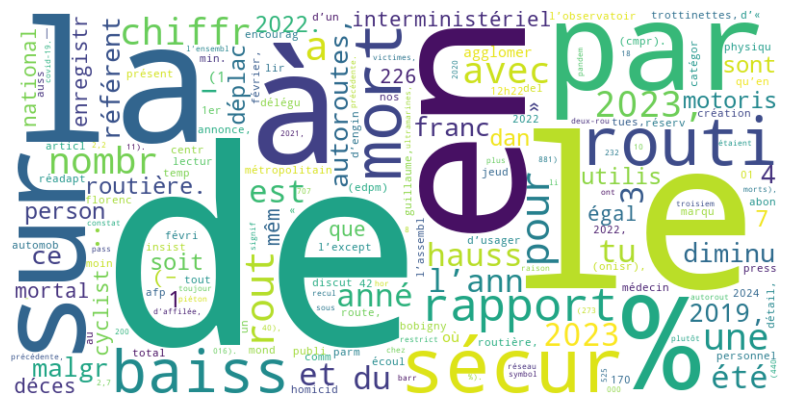

In [205]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='viridis'
).generate_from_frequencies(freq)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()




4. **Réduction de dimension (optionnel)**   
Pour simplifier les données et améliorer la modélisation (PCA, LSA).

5. **Modélisation / Apprentissage automatique**  
Les vecteurs sont maintenant exploitables par des modèles de ML :

- Si l’objectif est la classification (spam / pas spam, positif / négatif) :
On utilise : LogisticRegression, SVM, RandomForest, Naive Bayes, etc.

- Si l’objectif est le clustering (découverte de groupes de documents) :
Méthodes : KMeans, DBSCAN, Agglomerative Clustering, etc.

- Si l’objectif est la détection de thèmes (topic modeling) :
Modèles : LDA (Latent Dirichlet Allocation), NMF...

6. **Évaluation**  
Mesure de la performance du modèle avec des métriques adaptées.

7. **Interprétation et visualisation**  
Analyse des résultats, compréhension des patterns et présentation claire.

8. **Déploiement / Application**  
Intégration dans un système opérationnel, prise de décision, reporting.

Note :  
Selon le projet, certaines étapes peuvent être ajoutées, modifiées ou sautées.

